In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress

import viz

colors = viz.plotting_style()
lin_colors = list(colors.values())

plt.style.use('style.mpl')

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Single files per-organism of proteome level Z_C at different growth rates.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_21568/4237605842.py:13: DtypeWarning: Columns (0,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')


In [3]:
mask = coli_data.condition == 'glucose_minimal'
mask = np.logical_or(mask, coli_data.condition.str.startswith('chemostat'))
coli_chemostat = coli_data[mask].copy()

# Extract the ribosome profiling data
mask = coli_data.dataset == 'li_2014'
coli_li = coli_data[mask].copy()

# extract schmidt 2016 data in chemostat_conds
coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]

# extract schmidt 2016 minimal media non-stress conds
mm_conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate,acetate'.split(',')
mask = np.logical_and(coli_data.condition.isin(mm_conds), 
                      coli_data.dataset == 'schmidt_2016')
coli_schmidt_batch = coli_data[mask].copy()

/var/folders/bm/mmlmzvwn36sbfm6ks9_nddlw0000gn/T/ipykernel_21568/1194820238.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_')]


In [5]:
# Load biomass macromolecular composition from Bremer & Dennis 2008
bd_biomass_df = pd.read_excel('../data/physiology/BremerDennis_EcoSalPlus_2008.xlsx', index_col=0).T

# Calculate percent of biomass composition for RNA, protein and DNA as a function of growth rate.
cols = ['protein_ug_per_cell',
        'RNA_ug_per_cell',
        'DNA_ug_per_cell']
locs = [v for v in bd_biomass_df.index.values
        if v.startswith('u_')]

# Extract only the rows/columns we want
biomass_composition_df = bd_biomass_df[cols].loc[locs].copy()

# Get the total mass per cell from the parent DF
total_ug_per_cell = bd_biomass_df.loc[locs, 'mass_ug_per_cell']

# Extract the growth rate from the index
biomass_composition_df['growth_rate_hr'] = [float(v.strip('u_')) for v in biomass_composition_df.index.values]

# Calculate the mass fractions
biomass_percent_df = biomass_composition_df.copy()
biomass_percent_df[cols] = biomass_percent_df[cols].divide(total_ug_per_cell, axis=0)
biomass_percent_df[cols] = biomass_percent_df[cols].multiply(100) # pct
biomass_percent_df.columns = [c.replace('_ug_per_cell', '_percent') for c in biomass_percent_df.columns]
biomass_percent_df

,protein_percent,RNA_percent,DNA_percent,growth_rate_hr
u_0.6,60.176991,10.176991,3.362832,0.6
u_1.0,57.219251,11.764706,2.540107,1.0
u_1.5,53.153153,13.693694,2.162162,1.5
u_2.0,50.0,16.537468,1.899225,2.0
u_2.5,46.79696,19.543974,1.867535,2.5
u_3.0,41.642229,20.918866,1.896383,3.0


LinregressResult(slope=0.05396498065754272, intercept=-0.045652535304762785, rvalue=0.9968631549861929, pvalue=1.474426200245482e-05, stderr=0.002142235284755443, intercept_stderr=0.004181476459111925)


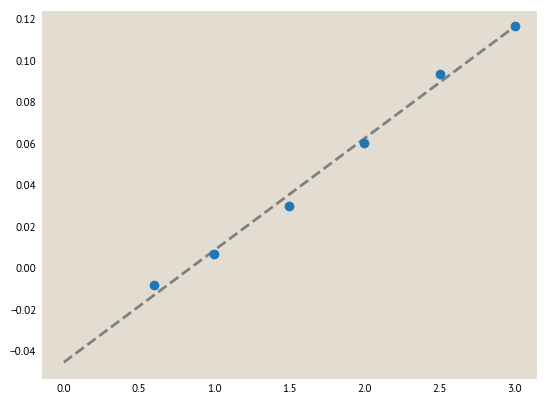

In [6]:
# Estimate ZC changes
cols = ['protein_percent', 'RNA_percent', 'DNA_percent']
ZCs = [-0.2, 0.9, 0.6]
inferred_ZCBs = (biomass_percent_df[cols]*ZCs/100).sum(axis=1)

reg_xs = biomass_percent_df.growth_rate_hr.values.astype(float)
reg_ys = inferred_ZCBs.values.astype(float)
lambda_ZCB_regression = linregress(reg_xs, reg_ys)
print(lambda_ZCB_regression)

lams = np.linspace(0, 3.0, 100)
plt.plot(lams, lambda_ZCB_regression.intercept + lambda_ZCB_regression.slope*lams, ls='--', color='grey')
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs, 'o')


/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/flamholz/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

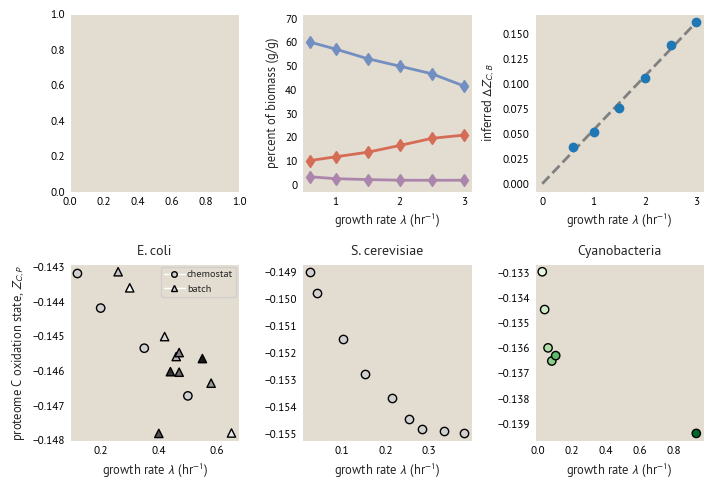

In [7]:
##### Figure 1 -- proteins expressed during faster growth are more reduced
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24,5))
pal = sns.color_palette()
greys = sns.color_palette('Greys')

# Top panels: expectations from E. coli physiology.
# Dependence of biomass fractional composition on growth rate -- 
# from Bremer and Dennis 2008 reprinted from earlier work. 
plt.sca(axs[0,1])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l, color=c)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('percent of biomass (g/g)')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)

plt.sca(axs[0,2])
lams = np.linspace(0, 3.0, 100)
# Estimate ZC changes relative to lambda = 0, i.e. the intercept of the regression
dZCB = lambda_ZCB_regression.slope*lams
plt.plot(lams, dZCB, ls='--', color='grey')
plt.plot(biomass_percent_df.growth_rate_hr, inferred_ZCBs - lambda_ZCB_regression.intercept, 'o')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('inferred $\Delta Z_{C,B}$')

# E. coli proteomes from Schmidt 2016
plt.sca(axs[1,0])
sns.scatterplot(data=coli_schmidt_chemostat, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='o', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
n_conds_batch = coli_schmidt_batch.condition.unique().size
sns.scatterplot(data=coli_schmidt_batch, x='growth_rate_hr', y='proteome_NOSC',
                hue='condition', palette=sns.color_palette('Greys', n_colors=n_conds_batch), 
                style='dataset', markers='^', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
plt.title('E. coli', style='italic')
plt.ylabel('proteome C oxidation state, $Z_{C,P}$')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='chemostat',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4),
                   Line2D([0], [0], marker='^', color='w', label='batch',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4)]
plt.gca().legend(handles=legend_elements, loc=1,
                 handletextpad=0.2, borderaxespad=0.3, borderpad=0.3)

# S. cerevisiae proteome data from Xia 2016
plt.sca(axs[1,1])
sns.scatterplot(data=yeast_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1)
plt.title('S. cerevisiae', style='italic')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('')

# Cyanobacterial proteome data from Zavrel 2019
plt.sca(axs[1,2])
# Color by light intensity
n_intensities = cyano_data.red_light_intensity_uE_m_s.unique().size
sns.scatterplot(data=cyano_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1,
                hue='red_light_intensity_uE_m_s',
                palette=sns.color_palette('Greens', n_colors=n_intensities),
                legend=False)
plt.title('Cyanobacteria')
plt.ylabel('')
plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')

plt.tight_layout()
plt.savefig('../output/Fig2.png', facecolor='w', dpi=300)
plt.show()